## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [4]:
# Let's import what we need, so we won't bother later
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle

%load_ext autoreload
% autoreload 2

## First, I'll compute the camera calibration using chessboard images

We define a function, that get the chessboard size, and keep the result in a pickle file

In [5]:
%matplotlib qt

def get_calibration_points(images, chessboard_size=(9,6), display=False, pickle_filename=None):
    try:
        # get the camera calibration from pickled file if available
        # otherwise compute them
        with open(pickle_filename, 'rb') as f:
            objpoints, imgpoints = pickle.load(f)
            return objpoints, imgpoints
    except FileNotFoundError:
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((chessboard_size[1]*chessboard_size[0],3), np.float32)
        objp[:,:2] = np.mgrid[0:chessboard_size[0],0:chessboard_size[1]].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        # Step through the list and search for chessboard corners
        for fname in images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, chessboard_size,None)

            # If found, add object points, image points
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

                if display:
                    # Draw and display the corners
                    img = cv2.drawChessboardCorners(img, chessboard_size, corners, ret)
                    cv2.imshow('img',img)
                    cv2.waitKey(500)
        if display:
            cv2.destroyAllWindows()
        if pickle_filename:
            pickle.dump( (objpoints, imgpoints), open(pickle_filename, "wb" ) )
        return objpoints, imgpoints


# *** Let's start ***

images = glob.glob('camera_cal/calibration*.jpg')  # Make a list of calibration images
objpoints, imgpoints = get_calibration_points(images, chessboard_size=(9,6), display=True,
                                             pickle_filename = 'calibration_points.pickle')

## With the calibration points we get the transformation matrix  

In [6]:
# Do camera calibration given object points and image points
img_size = (1280, 720)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

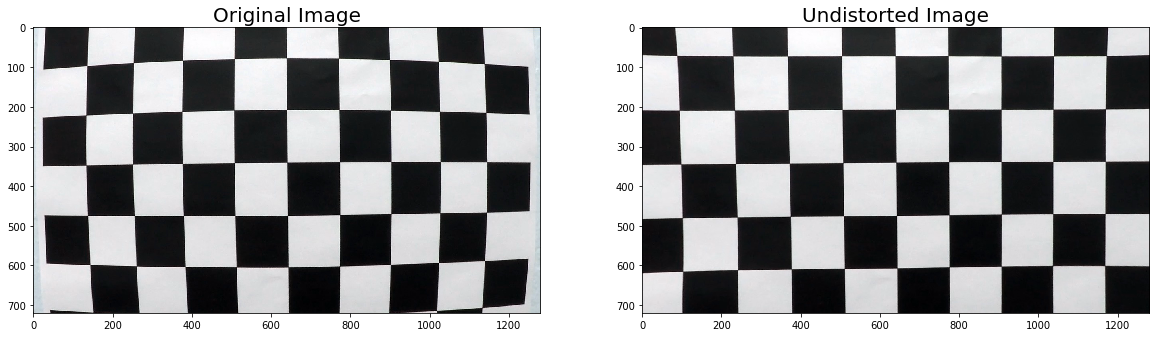

In [7]:
%matplotlib inline
# Test undistortion on an image

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()


## Let's try to undistort a real image

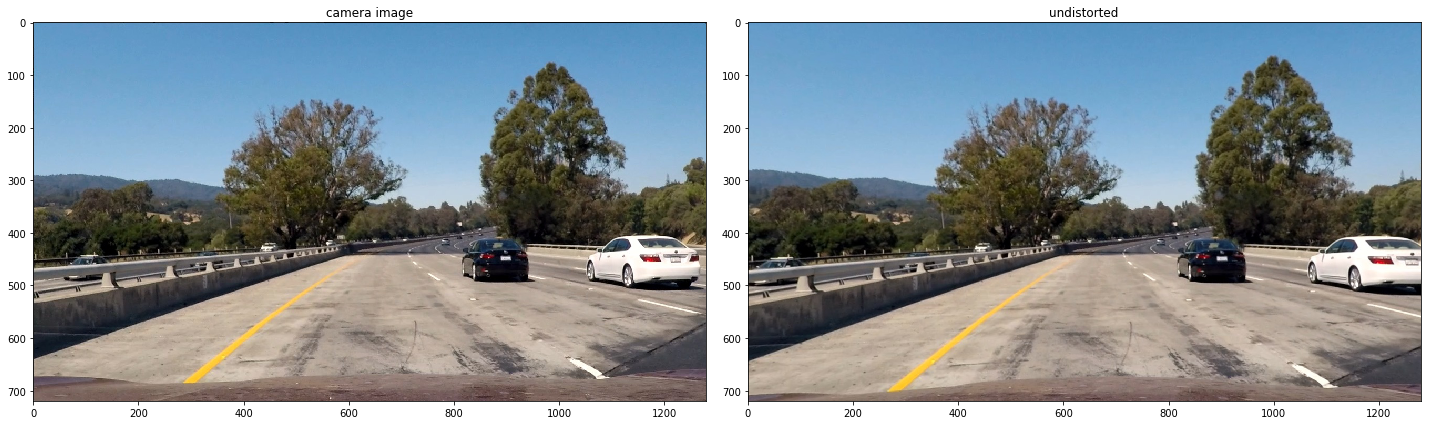

In [8]:
# Proceed with undistortion of the real images
img = mpimg.imread('test_images/test1.jpg')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('camera image')
undist = cv2.undistort(img, mtx, dist, None, mtx)
ax2.imshow(undist)
ax2.set_title('undistorted')
plt.show()


## Now let's get the edges

We combine the sobel-x gradient with a thresholded binary version of the saturation and scaled luminosity channels

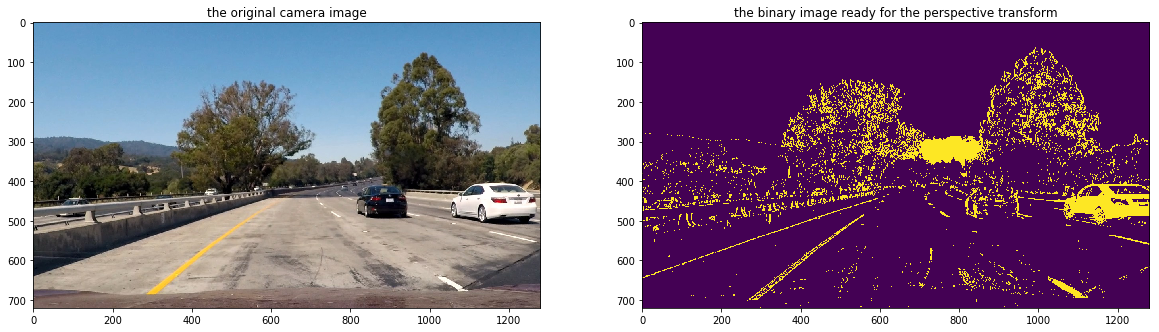

In [9]:
def binary(img,
           sobelx_thresh=(20, 200),
           luminosity_thresh=(200, 255),
           saturation_thresh=(200, 255),
           ):
    """ Give a color image, get a binary image with edges combining sobelx gradient
        and tresholded saturation channel and luminosity
    """
    # Convert to HSV color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:, :, 1]
    saturation_channel = hls[:, :, 2]

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    # Absolute x derivative to accentuate lines away from horizontal
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    scaled_luminosity = np.uint8(255 * l_channel / np.max(l_channel))

    # Binary composition of the 3 functions with their thresold
    composition = np.zeros_like(scaled_sobelx)
    composition[
        (scaled_sobelx >= sobelx_thresh[0]) & (scaled_sobelx < sobelx_thresh[1])
        |
        (saturation_channel >= saturation_thresh[0]) & (saturation_channel < saturation_thresh[1])
        |
        (scaled_luminosity >= luminosity_thresh[0]) & (scaled_luminosity < luminosity_thresh[1])
        ] = 255
    return composition


binary_image = binary(undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,20))
ax1.imshow(img)
ax1.set_title('the original camera image')
ax2.imshow(binary_image)
ax2.set_title('the binary image ready for the perspective transform')
plt.show()


## We are ready for the perspective transform

In the test images we have a couple of straight_lines images, we can use to choose how to build our transform matrix

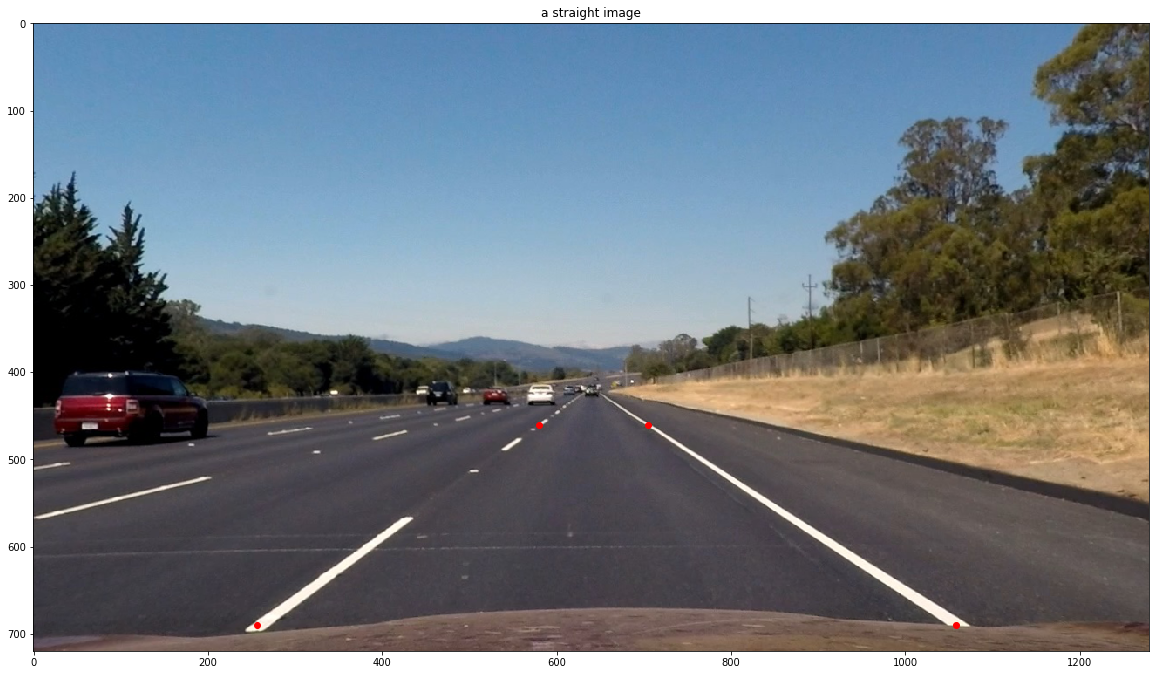

In [10]:
# %matplotlib qt
%matplotlib inline

straight_img = mpimg.imread('test_images/straight_lines2.jpg')
straight_undist = cv2.undistort(straight_img, mtx, dist, None, mtx)
# on this image I get the coordinate of 4 points that form a rectangle on the asphalt:
# one close point for each lane
# one far point for each lane

asphalt_box = np.array(
    [
        (690, 256), # left lane, close
        (460, 580), # left lane, far
        
        (690, 1058), # right lane, close
        (460, 705), # right lane, far
        
    ], dtype=np.float32
)

warped = binary_image

f, (ax1) = plt.subplots(1, 1, figsize=(20,20))
ax1.imshow(straight_undist)
ax1.set_title('a straight image')

for x, y in asphalt_box:
    ax1.plot(y, x, 'o', color='red', markersize=6)

plt.show()

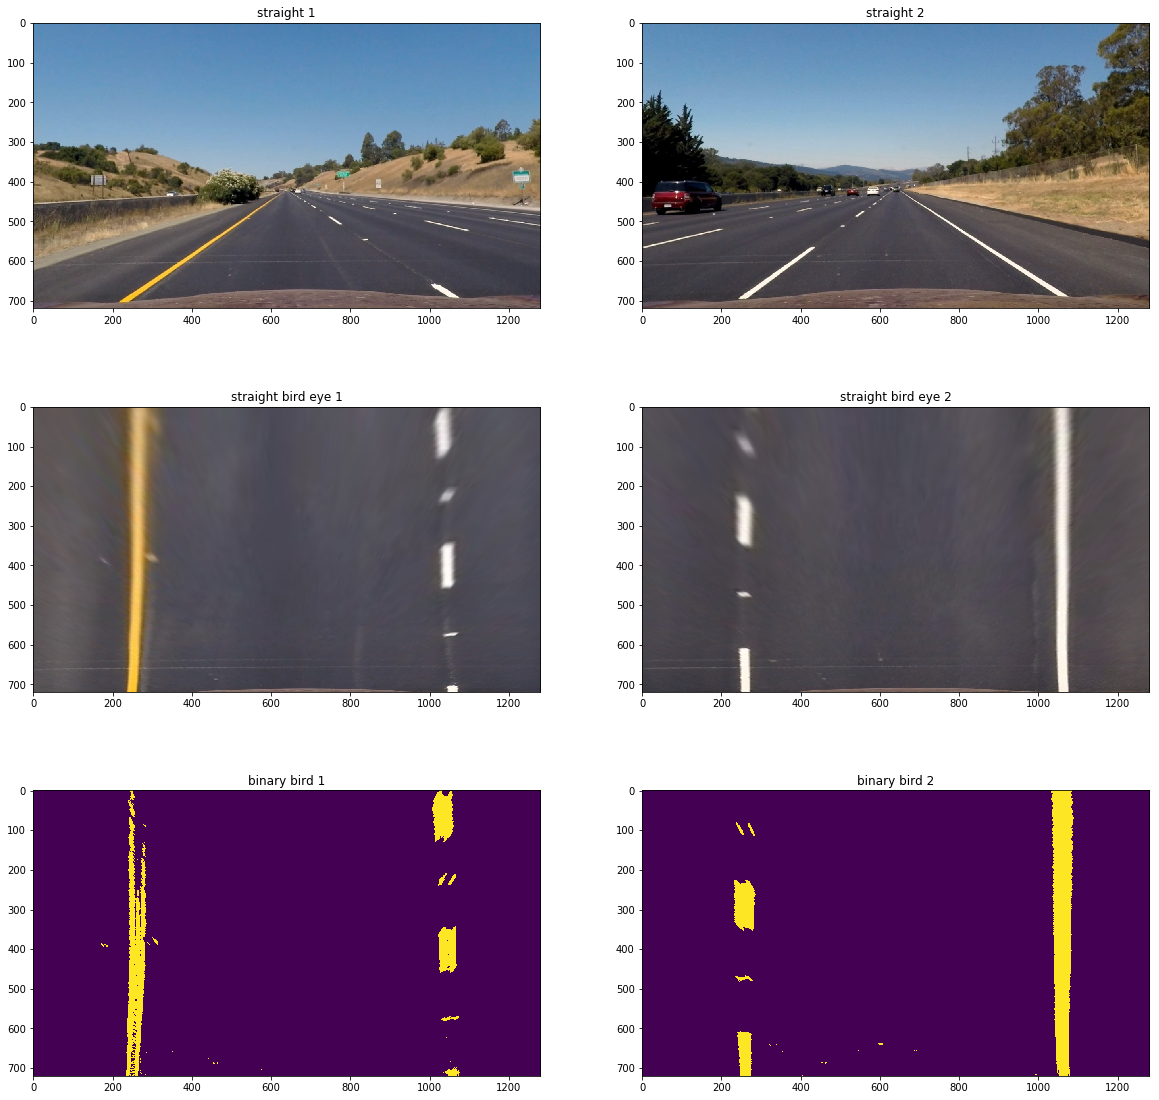

In [11]:
# now I choose how I want to transform it
# I keep the close points at the same place
# and bring the far one over them


def get_dstbox(bbox, shape):
    """ Build the destination box so that the srcbox x stays on bottom of image 
        while the top stays on top over them
    """
    imgmaxy, imgmaxx = shape
    minx, maxx = min(x for y,x in bbox), max(x for y,x in bbox)
    miny, maxy = min(y for y,x in bbox), max(y for y,x in bbox)
    return np.float32([
        (imgmaxy, minx), # bottom left
        (0, minx), # top right
        (imgmaxy, maxx), # bottom right
        (0, maxx), # top right
    ])
    
# Time to get the perspective transform matrix
src = straight_undist
img_size = src.shape[:2]
dstbox = get_dstbox(asphalt_box, shape=img_size)

# getPerspectiveTransform get X, Y tuples
M = cv2.getPerspectiveTransform(np.array([(x,y) for y, x in asphalt_box]),
                                np.array([(x, y) for y, x in dstbox])
                               )

straight_undist_1 = cv2.undistort(mpimg.imread('test_images/straight_lines1.jpg'), mtx, dist, None, mtx)
straight_undist_2 = cv2.undistort(mpimg.imread('test_images/straight_lines2.jpg'), mtx, dist, None, mtx)

warped1 = cv2.warpPerspective(straight_undist_1, M, img_size[::-1], flags=cv2.INTER_LINEAR)
warped2 = cv2.warpPerspective(straight_undist_2, M, img_size[::-1], flags=cv2.INTER_LINEAR)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(321)
ax1.set_title('straight 1')
ax1.imshow(straight_undist_1)

ax2 = fig.add_subplot(322)
ax2.set_title('straight 2')
ax2.imshow(straight_undist_2)

ax3 = fig.add_subplot(323)
ax3.set_title('straight bird eye 1')
ax3.imshow(warped1)

ax4 = fig.add_subplot(324)
ax4.set_title('straight bird eye 2')
ax4.imshow(warped2)

binary_image_1 = binary(warped1)
binary_image_2 = binary(warped2)

ax3 = fig.add_subplot(325)
ax3.set_title('binary bird 1')
ax3.imshow(binary_image_1)

ax4 = fig.add_subplot(326)
ax4.set_title('binary bird 2')
ax4.imshow(binary_image_2)

plt.show()

## it's time to get the lines out of it

/home/dario/Dropbox/selfdriving/source/p4_advanced_lane_detection/linefinder/convlines.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  r_sum = np.sum(img[int(3 * img.shape[0] / 4):, int(img.shape[1] / 2):], axis=0)
/home/dario/anaconda3/envs/drive/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


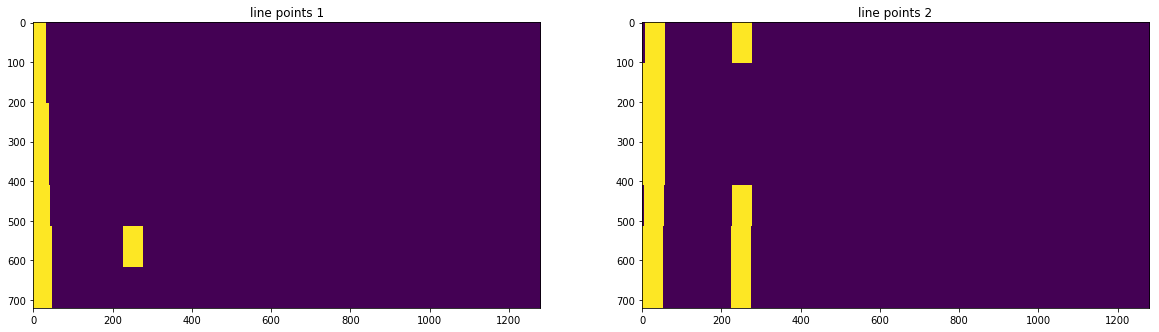

In [38]:
from linefinder.convlines import get_convoluted_lines, find_window_centroids, get_window_size

points_1l, points_1r = get_convoluted_lines(binary_image_1)
points_2l, points_2r = get_convoluted_lines(binary_image_2)

fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)
ax1.set_title('line points 1')
ax1.imshow(points_1l | points_1r)

ax2 = fig.add_subplot(222)
ax2.set_title('line points 2')
ax2.imshow(points_2l | points_2r)
plt.show()

In [37]:
from linefinder.func_radius import get_line_function

# Define conversions in x and y from pixels space to meters
YM_PER_PIX = 30 / 720  # meters per pixel in y dimension
XM_PER_PIX = 3.7 / 700  # meters per pixel in x dimension

img = binary_image_1
img_size = img.shape
linespacey = np.linspace(0, img_size[0]-1, num=img_size[0])  # to cover same y-range as image

window_width, window_height, margin = get_window_size(img)
c = find_window_centroids(img, window_width, window_height, margin)
l = c[:,0]
r = c[:,1]
print (c)
print (linespacey.shape)
print (points_1l.shape)
get_line_function(linespacey, l)

/home/dario/anaconda3/envs/drive/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


TypeError: list indices must be integers or slices, not tuple